# Построение модели на примере полиномиальной регрессии (polynomial regression)

## Подготовка окружения

In [1]:
# ВНИМАНИЕ: необходимо удостовериться, что виртуальная среда выбрана правильно!

# Для MacOS/Ubuntu
# !which pip

# Для Windows
# !where pip

In [2]:
# !conda install matplotlib numpy scikit-learn seaborn -y

In [3]:
import numpy as np

np.__version__

'1.19.2'

In [4]:
import pandas as pd

pd.__version__

'1.2.3'

In [5]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.__version__

'3.3.4'

In [6]:
import seaborn as sns

sns.__version__

'0.11.1'

## Загрузка данных

[Источник (FuelConsumption)](https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64)

In [7]:
df = pd.read_csv("./../../data/FuelConsumptionCo2.csv")
df

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,2014,VOLVO,XC60 AWD,SUV - SMALL,3.0,6,AS6,X,13.4,9.8,11.8,24,271
1063,2014,VOLVO,XC60 AWD,SUV - SMALL,3.2,6,AS6,X,13.2,9.5,11.5,25,264
1064,2014,VOLVO,XC70 AWD,SUV - SMALL,3.0,6,AS6,X,13.4,9.8,11.8,24,271
1065,2014,VOLVO,XC70 AWD,SUV - SMALL,3.2,6,AS6,X,12.9,9.3,11.3,25,260


## Преобразование типов и очистка

In [8]:
# удалить бессмысленную колонку
del df['MODELYEAR']

In [9]:
# преобразовать в правильные типы
df.MODEL = df.MODEL.astype("string")

for col_name in df.select_dtypes(include='object'):
    df[col_name] = df[col_name].astype("category")

In [10]:
df.ENGINESIZE = df.ENGINESIZE.astype(pd.CategoricalDtype(ordered=True))
df.CYLINDERS = df.CYLINDERS.astype(pd.CategoricalDtype(ordered=True))

## Удаление выбросов

In [11]:
def remove_outliers_iqr(data, col_name):
    print(f"column name: {col_name}\n")
    Q1 = data[col_name].quantile(0.25)
    Q3 = data[col_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR
    data_new = data[~((data[col_name] < lower_fence) |
                      (data[col_name] > upper_fence))]
    
    diff_len = len(data) - len(data_new)
    print(f"removed: {diff_len}")
    
    _, axs = plt.subplots(1, 2, figsize=(10, 2))
    sns.boxplot(data=data_new[col_name], ax=axs[0])
    sns.histplot(data=data_new[col_name], ax=axs[1])
    
    df = data_new.reset_index(drop=True)

column name: FUELCONSUMPTION_CITY

removed: 26
------------------------------ 

column name: FUELCONSUMPTION_HWY

removed: 35
------------------------------ 

column name: FUELCONSUMPTION_COMB

removed: 32
------------------------------ 

column name: FUELCONSUMPTION_COMB_MPG

removed: 13
------------------------------ 

column name: CO2EMISSIONS

removed: 6
------------------------------ 



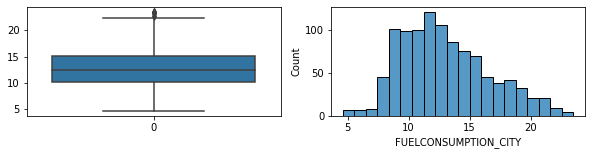

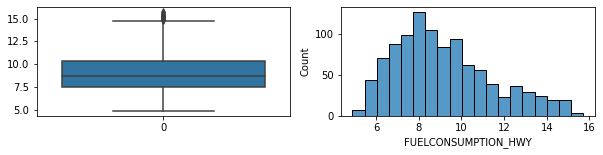

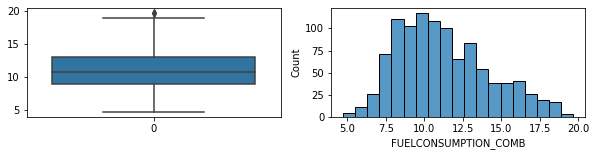

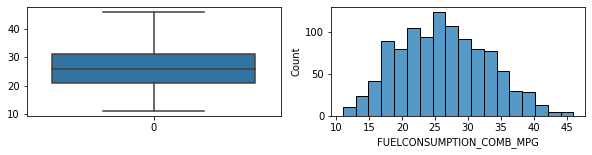

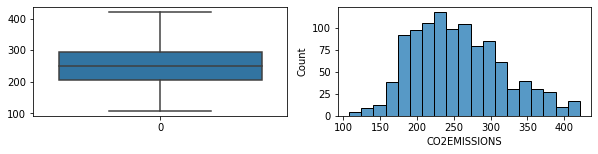

In [12]:
for col_name in df.select_dtypes(include=np.number):
    remove_outliers_iqr(df, col_name)
    print("-"*30, '\n')

## Нормализация

In [13]:
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()

df_num = df.select_dtypes(include=np.number)
df[df_num.columns] = robust_scaler.fit_transform(df_num)

## Стандартизация

In [14]:
# ухудшает качество
# from sklearn.preprocessing import QuantileTransformer

# quant_trans = QuantileTransformer(output_distribution='normal')
# df[df_num.columns] = quant_trans.fit_transform(df_num)

# df[df_num.columns].hist()
# all_in_one_plot()

## Преобразование категориальных признаков в числа

- `FUELTYPE` - номинальная
- `TRANSMISSION` - номинальная
- `MAKE` - номинальная
- `CYLINDERS` - порядковая
- `ENGINESIZE` - порядковая

In [15]:
df.CYLINDERS = df.CYLINDERS.replace(3, 4).replace(5, 4).replace(10, 8).replace(12, 8)

In [16]:
df.CYLINDERS.value_counts()

4    433
6    356
8    278
Name: CYLINDERS, dtype: int64

In [17]:
df.ENGINESIZE = df.ENGINESIZE.astype(float).round(0)
df.ENGINESIZE.value_counts()

2.0    391
4.0    284
5.0    138
3.0    112
6.0     93
1.0     38
7.0      9
8.0      2
Name: ENGINESIZE, dtype: int64

In [18]:
df.ENGINESIZE = df.ENGINESIZE.replace(1, 2).replace(7, 6).replace(8, 6)
df.ENGINESIZE.value_counts()

2.0    429
4.0    284
5.0    138
3.0    112
6.0    104
Name: ENGINESIZE, dtype: int64

In [19]:
df.FUELTYPE=df.FUELTYPE.replace('D', 'X')

In [20]:
from sklearn.preprocessing import OrdinalEncoder
enc_ord = OrdinalEncoder()
df[['CYLINDERS_enc', 'ENGINESIZE_enc']] = enc_ord.fit_transform(df[['CYLINDERS', 'ENGINESIZE']])
df[['CYLINDERS', 'CYLINDERS_enc', 'ENGINESIZE', 'ENGINESIZE_enc']]

,CYLINDERS,CYLINDERS_enc,ENGINESIZE,ENGINESIZE_enc
0,4,0.0,2.0,0.0
1,4,0.0,2.0,0.0
2,4,0.0,2.0,0.0
3,6,1.0,4.0,2.0
4,6,1.0,4.0,2.0
...,...,...,...,...
1062,6,1.0,3.0,1.0
1063,6,1.0,3.0,1.0
1064,6,1.0,3.0,1.0
1065,6,1.0,3.0,1.0


In [21]:
from sklearn.preprocessing import OneHotEncoder

enc_oh = OneHotEncoder()
enc_oh_result = enc_oh.fit_transform(df[['FUELTYPE', 
#                                          'TRANSMISSION', 
#                                          'MAKE'
                                        ]])
column_names = enc_oh.get_feature_names(['FUELTYPE_enc', 
#                                          'TRANSMISSION_enc', 
#                                          'MAKE_enc'
                                        ])
df_enc_oh_result = pd.DataFrame(enc_oh_result.toarray(), columns=column_names)
df_enc_oh_result

,FUELTYPE_enc_E,FUELTYPE_enc_X,FUELTYPE_enc_Z
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
...,...,...,...
1062,0.0,1.0,0.0
1063,0.0,1.0,0.0
1064,0.0,1.0,0.0
1065,0.0,1.0,0.0


In [22]:
df = df.join(df_enc_oh_result)

## Удаление категориальных колонок

In [23]:
df_cat = df.select_dtypes(include='category')
df_cat

,MAKE,VEHICLECLASS,CYLINDERS,TRANSMISSION,FUELTYPE
0,ACURA,COMPACT,4,AS5,Z
1,ACURA,COMPACT,4,M6,Z
2,ACURA,COMPACT,4,AV7,Z
3,ACURA,SUV - SMALL,6,AS6,Z
4,ACURA,SUV - SMALL,6,AS6,Z
...,...,...,...,...,...
1062,VOLVO,SUV - SMALL,6,AS6,X
1063,VOLVO,SUV - SMALL,6,AS6,X
1064,VOLVO,SUV - SMALL,6,AS6,X
1065,VOLVO,SUV - SMALL,6,AS6,X


In [24]:
df.drop(df_cat.columns.to_list(), inplace=True, axis=1)

In [25]:
df.select_dtypes(include='category')

""
0
1
2
3
4
...
1062
1063
1064
1065


In [26]:
del df['MODEL']

In [27]:
del df['ENGINESIZE']

## Удаление мультиколлинеарности

In [28]:
pd.set_option('display.max_rows', 100)

corr_matrix = df_num.corr()
corr_matrix[(abs(corr_matrix)) > 0.5]

,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
FUELCONSUMPTION_CITY,1.000000,0.965718,0.995542,-0.935613,0.898039
FUELCONSUMPTION_HWY,0.965718,1.000000,0.985804,-0.893809,0.861748
FUELCONSUMPTION_COMB,0.995542,0.985804,1.000000,-0.927965,0.892129
FUELCONSUMPTION_COMB_MPG,-0.935613,-0.893809,-0.927965,1.000000,-0.906394
CO2EMISSIONS,0.898039,0.861748,0.892129,-0.906394,1.000000


In [29]:
# улучшает качество модели
df.drop(['FUELCONSUMPTION_COMB', 'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_CITY'], inplace=True, axis=1)

## Разделение данных на `X` и `y`

In [30]:
from sklearn.model_selection import train_test_split

y = df['CO2EMISSIONS'].copy()
X = df.loc[:, df.columns != 'CO2EMISSIONS'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [31]:
X_train

,FUELCONSUMPTION_COMB_MPG,CYLINDERS_enc,ENGINESIZE_enc,FUELTYPE_enc_E,FUELTYPE_enc_X,FUELTYPE_enc_Z
726,0.1,1.0,2.0,0.0,0.0,1.0
959,0.3,0.0,0.0,0.0,1.0,0.0
903,-0.1,1.0,1.0,0.0,0.0,1.0
947,1.0,0.0,0.0,0.0,1.0,0.0
1062,-0.2,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...
750,-0.4,2.0,4.0,0.0,0.0,1.0
334,1.0,0.0,0.0,0.0,1.0,0.0
715,1.1,0.0,0.0,0.0,1.0,0.0
586,-0.3,1.0,2.0,0.0,1.0,0.0


## Полиномиальная линейная регрессия

In [32]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_train_poly

array([[ 1. ,  0.1,  1. , ...,  0. ,  0. ,  1. ],
       [ 1. ,  0.3,  0. , ...,  0. ,  0. ,  0. ],
       [ 1. , -0.1,  1. , ...,  0. ,  0. ,  1. ],
       ...,
       [ 1. ,  1.1,  0. , ...,  0. ,  0. ,  0. ],
       [ 1. , -0.3,  1. , ...,  0. ,  0. ,  0. ],
       [ 1. , -0.8,  2. , ...,  0. ,  0. ,  1. ]])

In [33]:
from sklearn.linear_model import LinearRegression
poly_regr = LinearRegression()
poly_regr.fit(X_train_poly, y_train)

print('Coefficients: ', poly_regr.coef_)
print('Intercept: ', poly_regr.intercept_)

Coefficients:  [-4.49871319e-13  7.27786196e+07  1.26033010e+08  8.27539067e+08
 -2.62243970e+08  1.46530833e+08  1.67228225e+08 -1.54123392e+08
 -8.59301213e+07 -1.10098931e+08  4.17581018e+07 -1.98619032e+08
  3.65478390e+08 -6.05937787e+08 -1.60399482e+09 -9.06607195e+08
 -4.07651168e+07 -1.32031885e+09 -9.69866848e+09 -1.27624882e+09
 -1.46731931e+08 -1.62782601e+09 -1.32737330e+08  6.41750276e+06
 -1.88574242e+07  5.22349425e+08  1.13960596e+07 -3.07218810e+08
 -4.92904484e-02  4.04429529e-01 -1.41181502e-01  1.54123392e+08
  1.54123392e+08  1.54123392e+08  1.37459539e-01 -4.15085852e-02
  8.59301221e+07  8.59301214e+07  8.59301213e+07 -2.07178295e-02
  1.10098930e+08  1.10098931e+08  1.10098931e+08 -1.14536722e+08
  0.00000000e+00  0.00000000e+00  1.25840411e+08  0.00000000e+00
 -4.38257010e+08 -2.64129242e+08 -7.27625309e+06  6.24970126e+08
  9.08870645e+08  1.65760545e+09  1.29639970e+08  2.13989903e+09
  1.85599851e+09  1.10726370e+09  5.09353426e+08  0.00000000e+00
  0.000000

In [34]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(poly_regr, X_test, y_test, cv=5)
print(f"scores: {scores}")
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores: [0.93431159 0.91538625 0.91076812 0.92300566 0.84227683]
0.91 accuracy with a standard deviation of 0.03


In [35]:
from sklearn.metrics import r2_score

X_test_poly = poly.transform(X_test)
y_predicted = poly_regr.predict(X_test_poly)

print("Mean absolute error: %.2f" % np.mean(np.absolute(y_predicted - y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_predicted - y_test) ** 2))
print("R2-score: %.2f" % r2_score(y_true=y_test, y_pred=y_predicted))

Mean absolute error: 0.04
Residual sum of squares (MSE): 0.00
R2-score: 0.99


## Cross-validation

[sklearn.model_selection.cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

In [36]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(poly_regr, X_test_poly, y_test, cv=5)
print(f"scores: {scores}")
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores: [0.97127163 0.98079272 0.98948319 0.97809239 0.98588206]
0.98 accuracy with a standard deviation of 0.01
